<a href="https://colab.research.google.com/github/PranjalVyas1507/DeepLearning---Colab-notebooks/blob/main/Vision_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 4.0 MB/s 


In [ ]:
import tensorflow as tf
import tensorflow.keras as keras

In [ ]:
from keras.layers import Dense, MultiHeadAttention, BatchNormalization
import numpy as np
import tensorflow_addons as tfa 

In [ ]:
num_classes = 100
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}") 

169017344/169001437 [==============================] - 11s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [ ]:
learning_rate = 0.0001
weight_decay = 0.00001

epochs = 200
batch_size = 256
image_size = 72
patch_size = 6
num_patches = (image_size // patch_size) ** 2

projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024] 

In [ ]:
from keras import Sequential
from keras.layers import Normalization, Resizing, RandomFlip, RandomRotation, RandomZoom

In [ ]:
data_augmentation = Sequential(
    [
      Normalization(),
     Resizing(image_size,image_size),
     RandomFlip("horizontal"),
     RandomRotation(0.0002),
     RandomZoom(height_factor=0.2,width_factor=0.2)
    ],
    name="data_augmentation")

data_augmentation.layers[0].adapt(x_train)

In [ ]:
def mlp(x, hidden_units,dropout):
  for units in hidden_units:
    x = Dense(units,activation='relu')(x)
    x = Dropout(dropout)(x)
  return x

In [ ]:
from keras.layers import Layer

class Patch(Layer):
  def __init__(self,patch_size):
    super(Patch, self).__init__()
    self.patch_size = patch_size

  def call(self, images):
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(
        images = images,
        sizes = [1, self.patch_size, self.patch_size, 1],
        strides = [1, self.patch_size, self.patch_size, 1],
        rates = [1,1,1,1],
        padding = "VALID",
    )

    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches,[batch_size, -1, patch_dims])
    return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


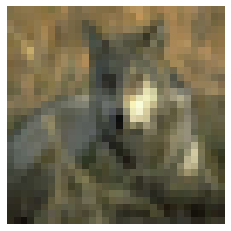

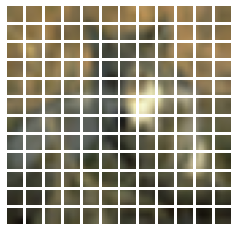

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patch(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
class PatchEncoder(Layer):
  def __init__(self, num_patches, projection_dim):
    super(PatchEncoder, self).__init__()
    self.num_patches = num_patches
    self.projection = keras.layers.Dense(units=projection_dim)
    self.position_embedding = keras.layers.Embedding(input_dim=num_patches, 
                                               output_dim=projection_dim
                                               )

  def call(self, patch):
    positions = tf.range(start=0, limit=self.num_patches, delta=1)
    encoded = self.projection(patch) + self.position_embedding(positions)
    return encoded

In [ ]:
from keras.layers import Input, LayerNormalization, Add, Flatten, Dropout
from keras import Model
input_shape = (32, 32, 3)



def create_vit_classifier():
  inputs = Input(shape=input_shape)
  augmented = data_augmentation(inputs)
  patches = Patch(patch_size)(augmented)
  encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

  for _ in range(transformer_layers):
    x1 = LayerNormalization(epsilon=1e-6)(encoded_patches)
    attention_output = MultiHeadAttention(num_heads=num_heads, 
                                          key_dim=projection_dim, dropout=0.1)(x1,x1)
    x2 = Add()([attention_output,encoded_patches])
    x3 = LayerNormalization(epsilon=1e-6)(x2)
    x3 = mlp(x3, hidden_units=transformer_units, dropout=0.1)

    encoded_patches = Add()([x3,x2])

  representation = LayerNormalization(epsilon=1e-6)(encoded_patches)
  representation = Flatten()(representation)
  representation = Dropout(0.5)(representation)

  features = mlp(representation, hidden_units=mlp_head_units, dropout=0.5)
  logits = Dense(num_classes)(features)
  model = Model(inputs=inputs, outputs=logits)

  return model


In [13]:
def run(model):
  optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

  model.compile(optimizer=optimizer, 
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics = [
                           keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                           keras.metrics.SparseTopKCategoricalAccuracy(5,name="top5accuracy")
                ]
  )

  checkpoint_filepath = "/tmp/checkpoint"
  checkpoint_callback = keras.callbacks.ModelCheckpoint(
      checkpoint_filepath,
      monitor = "val_accuracy",
      save_best_only = True,
      save_weights_only = True
  )

  history = model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs= 75, validation_split = 0.1, callbacks=[checkpoint_callback])

  model.load_weights(checkpoint_filepath)
  _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)

  print(f"Test accuracy: {round(accuracy * 100, 2)}%")
  print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

  return history

vit_classifier = create_vit_classifier()
history = run(vit_classifier)  

Epoch 1/75
176/176 [==============================] - 148s 766ms/step - loss: 4.7996 - accuracy: 0.0266 - top5accuracy: 0.1014 - val_loss: 4.3012 - val_accuracy: 0.0686 - val_top5accuracy: 0.2236
Epoch 2/75
176/176 [==============================] - 134s 764ms/step - loss: 4.3300 - accuracy: 0.0538 - top5accuracy: 0.1840 - val_loss: 4.0341 - val_accuracy: 0.1104 - val_top5accuracy: 0.3034
Epoch 3/75
176/176 [==============================] - 135s 765ms/step - loss: 4.1338 - accuracy: 0.0772 - top5accuracy: 0.2400 - val_loss: 3.8412 - val_accuracy: 0.1282 - val_top5accuracy: 0.3430
Epoch 4/75
176/176 [==============================] - 135s 767ms/step - loss: 3.9899 - accuracy: 0.0947 - top5accuracy: 0.2835 - val_loss: 3.7134 - val_accuracy: 0.1464 - val_top5accuracy: 0.3704
Epoch 5/75
176/176 [==============================] - 135s 766ms/step - loss: 3.8698 - accuracy: 0.1114 - top5accuracy: 0.3145 - val_loss: 3.5715 - val_accuracy: 0.1646 - val_top5accuracy: 0.4144
Epoch 6/75
176/176 [

NameError: ignored